In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import clone_model

from dm_control import suite
from dm_control import viewer

#import gym
from matplotlib import pyplot as plt

In [15]:
def convert_observation(obs):
    list1 = [i.tolist() for i in list(obs.values())]
    list2 = []
    for sublist in list1:
        try:
            list2.extend(sublist)
        except:
            list2.append(sublist)
    return list2

In [27]:
class Agent:
    def __init__(self, action_spec):
        self.memory = {
            "state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
        }
        self.random_proba = 1.0
        self.batch_size=64
        self.discount_rate=0.99
        self.tau=0.001
        self.action_dim = len(action_spec.minimum) #action_spec.shape
        self.action_spec = action_spec
        self.action_bound = 1
        self.input_size = 25

        # create critic model:
        #input_obs = tf.keras.Input(shape=(self.input_size,))
        input_obs = tf.keras.Input(shape=self.input_size)
        input_actions = tf.keras.Input(shape=(self.action_dim,))
        h = tf.keras.layers.Dense(64, activation = 'relu')(input_obs)
        #h = BatchNormalization()(h)
        tmp1 = tf.keras.layers.Dense(64)(h)
        action_abs = tf.keras.layers.Dense(64, activation = 'relu')(input_actions)
        #action_abs = Activation('relu')(action_abs)
        #action_abs = BatchNormalization()(action_abs)
        h = tf.keras.layers.Add()([tmp1,action_abs])
        #h = Dense(64)(h)
        h = tf.keras.layers.Activation('relu')(h)
        #h = BatchNormalization()(h)
        pred = tf.keras.layers.Dense(1, kernel_initializer='random_uniform')(h)
        model = tf.keras.Model(inputs=[input_obs, input_actions], outputs=pred)
        model.compile(optimizer='Adam',loss='mean_squared_error')
        self.critic_model = model
        
        # create actor model:
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(400, input_dim = self.input_size))#, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.Dense(300))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.Dense(self.action_dim, activation = "tanh"))
        model.compile(loss='mse', optimizer="Adam")
        self.actor_model = model
        
        # target models:
        self.target_critic_model = clone_model(self.critic_model)
        self.target_actor_model = clone_model(self.actor_model)
 
    def sample_action(self, obs):
        action = self.actor_model.predict(obs)
        #gaussian_noise = GaussianNoiseGenerator(self.action_spec.shape, -1, 1, 0.3)
        action = action +  np.random.normal(0, 0.3, self.action_spec.shape) # random_policy(-0.1, 0.1, size=self.action_spec.shape) #gauss noize?
        return action
    
    def store_info(self, obs, new_obs, action, reward, done):
        if len(self.memory["state"])>0:
            self.memory["state"] = np.vstack((self.memory["state"], obs))
            self.memory["new_state"] = np.vstack((self.memory["new_state"], new_obs))
        else:
            self.memory["state"] = np.array(obs)
            self.memory["new_state"] = np.array(new_obs)
        self.memory["action"] = np.append(self.memory["action"], action)
        self.memory["reward"] = np.append(self.memory["reward"], reward)
        self.memory["done"] = np.append(self.memory["done"], done)        
        
        
    def experience_replay(self):
        if len(self.memory["state"])>=self.batch_size:
            # get batch
            idxs = np.random.randint(len(self.memory["done"]), size=self.batch_size)
            batch = {
                "state": np.squeeze(self.memory["state"][idxs]), 
                "action": self.memory["action"][idxs], 
                "reward": self.memory["reward"][idxs], 
                "new_state": np.squeeze(self.memory["new_state"][idxs]), 
                "done": self.memory["done"][idxs]
            }
            
            # replay:
            #target_q = self.critic_model.predict_on_batch([batch["new_state"], 
            #                                self.actor_model.predict(batch["new_state"])])
            target_q = self.target_critic_model.predict_on_batch([batch["new_state"], 
                                            self.target_actor_model.predict(batch["new_state"])])
            y = batch["reward"] + self.discount_rate*target_q*(1-batch["done"])
            
            # update critic
            self.critic_model.train_on_batch([batch["state"], batch["action"]], 
                                                   np.reshape(y, (self.batch_size, 1)))    
            
           
            # update actor policy
            actions_pred = self.actor_model.predict(batch["state"])
            self.actor_model.fit(batch["state"], actions_pred, epochs = 1, verbose = 0)    
            
            # update networks           
            critic_weights =  self.critic_model.get_weights()
            actor_weights = self.actor_model.get_weights()
            
            old_critic_target_weights = self.target_critic_model.get_weights()
            old_actor_target_weights = self.target_actor_model.get_weights()
            
            for i in range(len(critic_weights)):
                old_critic_target_weights[i] = self.tau*old_critic_target_weights[i] + (1-self.tau)*critic_weights[i]
            self.critic_model.set_weights(old_critic_target_weights)
            
            for i in range(len(actor_weights)):
                old_actor_target_weights[i] = self.tau*old_actor_target_weights[i] + (1-self.tau)*actor_weights[i]
            self.actor_model.set_weights(old_actor_target_weights)
                
                
            #target_weights = self.tau*critic_weights + (1-self.tau)*target_weights




In [29]:
env = suite.load(domain_name="swimmer", task_name="swimmer6")
action_spec = env.action_spec()

agent = Agent(action_spec)

In [ ]:
# https://www.tensorflow.org/guide/effective_tf2?hl=ru
# https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#d4pg

In [2]:
def train_model(env, n_max_steps, batch_size, discount_rate):
    iter_num_to_check_stop = 100
    scores = np.array([])
    action_spec = env.action_spec()
    agent = Agent(action_spec)

    for iteration in range(n_iterations):
        if iteration == iter_num_to_check_stop:
            last_negative_reward_index = np.argwhere(scores<0)[-1]
            positive_tail_length = iteration - last_negative_reward_index
            if positive_tail_length >= 100:
                break
            else:
                iter_num_to_check_stop = last_negative_reward_index + 100

        obs = env.reset()  
        obs = convert_observation(obs)

        game_score = 0
        for step in range(n_max_steps):       
            # get action:
            action = agent.sample_action(obs)
            # make action:
            new_obs, reward, done, info = env.step(action[0])
            new_obs = convert_obs(new_obs)
            
            # update history:
            game_score += reward   
            agent.store_info(obs, new_obs, action, reward, done)
            obs = new_obs
            # experience replay:
            agent.experience_replay()
            if done:
                break

        scores = np.append(scores, game_score)
        if (iteration+1) % 100 == 0:
            print('Avg score for the last {} games: {}'.format(100, np.mean(scores[-100:])))
    print("Evaluate in {} iterations".format(iteration+1))
    return scores, agent


Using TensorFlow backend.


Evaluate in 3 iterations


In [ ]:
n_iterations = 200

env = gym.make('Pendulum-v0')
n_max_steps = 3000

scores, agent = train_model(env, n_max_steps, batch_size, discount_rate)

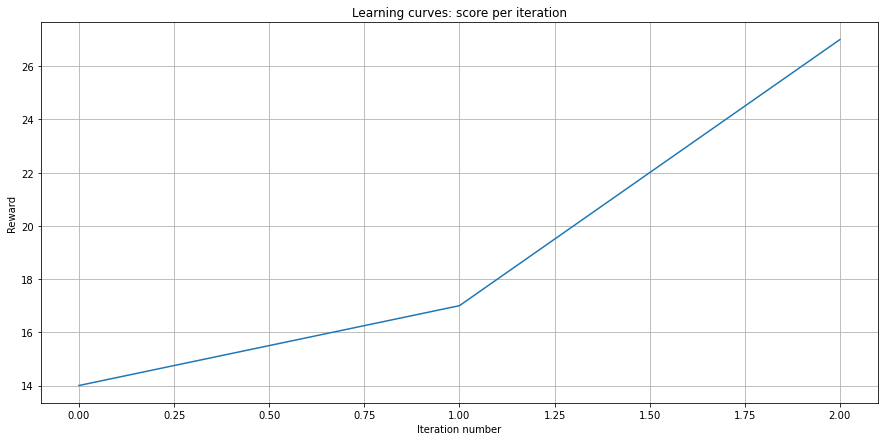

Average reward on test 100 games:  22.25


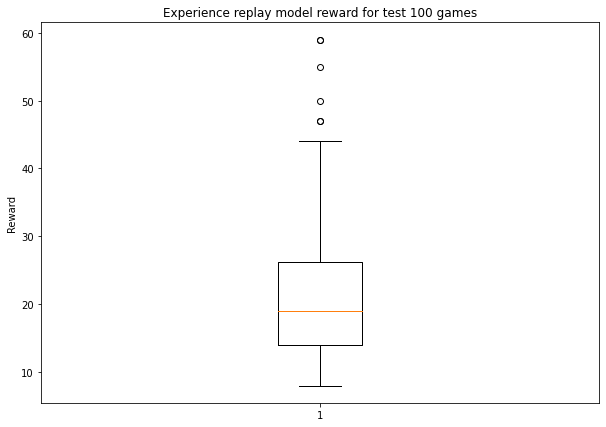

In [3]:
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(len(scores)))
plt.plot(x, scores)

plt.title("Learning curves: score per iteration")
plt.ylabel("Reward")
plt.xlabel("Iteration number")
plt.savefig("learning_curves.png")
plt.show()

test_games = 100

test_scores = []
for game_index in range(test_games):
    score = 0
    obs = env.reset()
    for step in range(n_max_steps): 
        obs = convert_observation(obs)
        action = agent.sample_action(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        if done:
            break
    test_scores.append(score)

print("Average reward on test 100 games: ", np.mean(test_scores))

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Experience replay model reward for test 100 games')
ax.boxplot(test_scores,   
          showfliers=True)

ax.set_ylabel("Reward")
plt.savefig("rewards.png")
plt.show()

agent.model.save('my_model.h5')

In [ ]:
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(len(scores)))
plt.plot(x, scores)

plt.title("Learning curves: score per iteration")
plt.ylabel("Reward")
plt.xlabel("Iteration number")
plt.savefig("learning_curves.png")
plt.show()

test_games = 100

test_scores = []
for game_index in range(test_games):
    score = 0
    obs = env.reset()
    for step in range(n_max_steps): 
        obs = convert_observation(obs)
        action = agent.sample_action(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        if done:
            break
    test_scores.append(score)

print("Average reward on test 100 games: ", np.mean(test_scores))

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Experience replay model reward for test 100 games')
ax.boxplot(test_scores,   
          showfliers=True)

ax.set_ylabel("Reward")
plt.savefig("rewards.png")
plt.show()

agent.model.save('my_model.h5')

In [1]:
import tensorflow as tf

In [13]:
from dm_control import suite
from dm_control import viewer
import numpy as np

env = suite.load(domain_name="swimmer", task_name="swimmer6")
action_spec = env.action_spec()

# Define a uniform random policy.
def random_policy(time_step):
    #del time_step  # Unused.    
    return np.random.uniform(low=action_spec.minimum,
                           high=action_spec.maximum,
                           size=action_spec.shape)

# Launch the viewer application.
viewer.launch(env, policy=random_policy)